In [1]:
%matplotlib inline
import cv2
import numpy as np
import os
import sys
import time
from matplotlib import pyplot as plt
from IPython import display

In [2]:
#load jumper template
jumper_template = cv2.imread('jumper.png')
template_h,template_w = jumper_template.shape[0:2]


In [3]:
screen_x, screen_y = 1080,1920
screen_x_eff, screen_y_eff = 1125,1958
jumper_foot_offset = 20
holdDt = 1.392
tap_x, tap_y = 600,1000

background_xy = (10,980)
header_y,foot_y = 500,1200

In [4]:
img = cv2.imread('scrshot - Copy.png')
background_color = img[background_xy[1],background_xy[0],:]

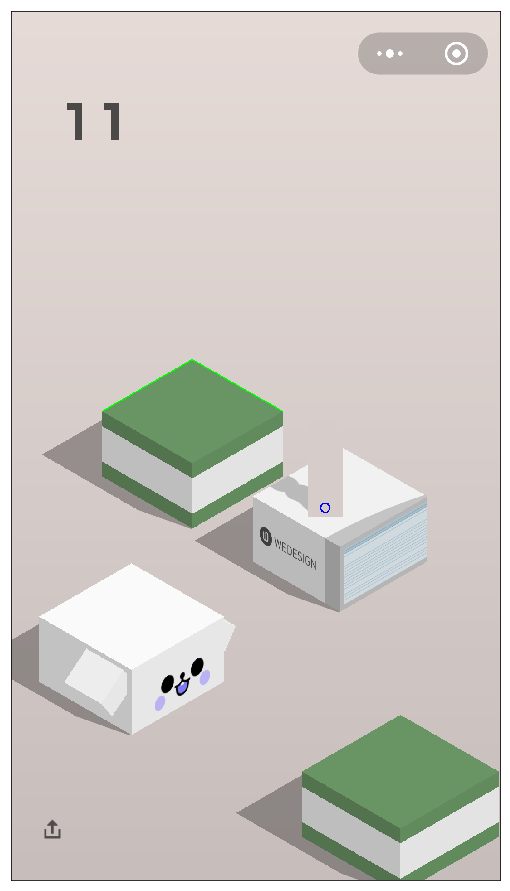

In [5]:
res = cv2.matchTemplate(img,jumper_template,cv2.TM_SQDIFF_NORMED) #find jumper template matching
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

top_left = min_loc
bottom_right = (top_left[0] + template_w, top_left[1] + template_h)

jumper_xy = (top_left[0]+int(template_w*0.5), top_left[1]+template_h-jumper_foot_offset) #jumper base location
mirrored_xy = (screen_x_eff-jumper_xy[0],screen_y_eff-jumper_xy[1])  #mirror the jumper base location to get the target base location

img[top_left[1]:bottom_right[1]+1,top_left[0]:bottom_right[0]+1,:]=background_color

img = cv2.circle(img,jumper_xy, 10, (0,0,255), 2)   # highlight where the jumper center is found


#img = cv2.GaussianBlur(img,(3,3),0)

canny = cv2.Canny(img, 1,10) 
canny[0:header_y,:] = 0
canny[foot_y:,:] = 0

y_top = np.nonzero([max(row) for row in canny])[0][0]

x_top_left = np.min(np.nonzero(canny[y_top]))
x_top_right = np.max(np.nonzero(canny[y_top]))
x_top = int(np.mean(np.nonzero(canny[y_top])))

topcorner_xy = (x_top,y_top);

if (x_top_right-x_top_left>7): #then this is a circle disk
    y_bot_startSearch = y_top+80
    y_bot = np.nonzero(canny[y_bot_startSearch:,x_top])[0][0]+y_bot_startSearch
    cv2.line(img,(x_top,y_top),(x_top,y_bot),255,2)
    target_xy = (x_top,int(y_top+y_bot)/2)
else: #this is a box
    #search left boundary
    target_color = img[y_top+1,x_top];
    y_current = y_top;
    x_current = x_top;
    while True:
        y_current += 1;
        x_search_range = range(x_current-5,x_current+1);
        color_diff = np.linalg.norm(img[y_current,x_search_range,:]-target_color,axis=1)
        if np.min(color_diff)<30:
            x_current = x_search_range[np.argmin(color_diff)];
            target_color = img[y_current,x_current];
        else: #found corner
            leftcorner_xy = (x_current,y_current-1);
            break;
    
    #search right boundary
    target_color = img[y_top+1,x_top];
    y_current = y_top;
    x_current = x_top;
    while True:
        y_current += 1;
        x_search_range = range(x_current+5,x_current,-1);
        color_diff = np.linalg.norm(img[y_current,x_search_range,:]-target_color,axis=1)
        if np.min(color_diff)<30:
            x_current = x_search_range[np.argmin(color_diff)];
            target_color = img[y_current,x_current];
        else: #found corner
            rightcorner_xy = (x_current,y_current-1);
            break;
    img = cv2.line(img,topcorner_xy,leftcorner_xy, (0,255,0), 2)   # highlight where the jumper center is found
    img = cv2.line(img,topcorner_xy,rightcorner_xy, (0,255,0), 2)   # highlight where the jumper center is found

    target_xy = mirrored_xy; 
     
fig=plt.figure(figsize=(18, 16))
plt.subplot(111)
plt.imshow(img,cmap='Greys')
plt.xticks([]), plt.yticks([])
plt.show()

